In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./df_guardado_clean.csv')

In [3]:
df.head()

,order_id,Fecha,Hora,avg_actual_delivery_time_minutes,avg_promised_delivery_time_minutes,to_pickup,to_dropoff,Vendor_id,llueve,ph
0,131748347,Viernes,13,69.100000,31.900000,1.348,0.489,1,1,0
1,131749603,Viernes,13,36.700000,30.883333,0.359,0.513,1,1,0
2,131748367,Viernes,13,32.833333,32.666667,0.735,0.684,1,1,0
3,131743177,Viernes,12,39.383333,40.600000,0.166,2.121,1,1,0
4,131738512,Viernes,11,29.450000,35.883333,2.924,2.898,1,1,0


# Benchmark: Error que trae el modelo actual

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
Z = df
RMSE_py = np.sqrt(mean_squared_error(Z['avg_actual_delivery_time_minutes'], Z['avg_promised_delivery_time_minutes'])).round(2)
MAE_py = mean_absolute_error(Z['avg_actual_delivery_time_minutes'], Z['avg_promised_delivery_time_minutes']).round(2)
RMSE_py, MAE_py

(12.04, 8.2)

In [6]:
X = df[df['Vendor_id']<12].drop(['avg_actual_delivery_time_minutes'
                                 #,'avg_promised_delivery_time_minutes'
                                ], axis=1)
X = pd.get_dummies(X, columns=['Vendor_id', 'Fecha'])

In [7]:
y = df[df['Vendor_id']<12]['avg_actual_delivery_time_minutes']

In [8]:
X.columns

Index(['order_id', 'Hora', 'avg_promised_delivery_time_minutes', 'to_pickup',
       'to_dropoff', 'llueve', 'ph', 'Vendor_id_1', 'Vendor_id_2',
       'Vendor_id_3', 'Vendor_id_4', 'Vendor_id_5', 'Vendor_id_6',
       'Vendor_id_7', 'Vendor_id_8', 'Vendor_id_9', 'Vendor_id_10',
       'Vendor_id_11', 'Fecha_Domingo', 'Fecha_Jueves', 'Fecha_Lunes',
       'Fecha_Martes', 'Fecha_Miercoles', 'Fecha_Sabado', 'Fecha_Viernes'],
      dtype='object')

# 0) Imports, custom func & split

In [9]:
#sklearn important imports

#Models
#1
from sklearn.ensemble import RandomForestRegressor
#2
from sklearn.tree import DecisionTreeRegressor
#3
from sklearn.ensemble import AdaBoostRegressor
#4
from sklearn.ensemble import GradientBoostingRegressor
#5
from sklearn.svm import SVR
#6
#ANN in an other notebook for compitibilty

#Support
#Train test holdout split
from sklearn.model_selection import train_test_split
# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
def split_Xy(X_,y_, hold_out_size=1/10, test_size=2/9, random_state=42):
    
    """
    Funcion split_Xy:
            devuelve los splits como tuplas globales
            permite elegir los ratios de split y el random state

    * Debes importar lo siguente:
    from sklearn.model_selection import train_test_split
    """    
    
    #make variable global
    global X, X_holdout, X_train, X_test, y, y_holdout, y_train, y_test
    
    
    #create tuples
    (X), (X_holdout), (y), (y_holdout) = train_test_split(X_, y_, test_size=hold_out_size, random_state=random_state)
    (X_train), (X_test), (y_train), (y_test) = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print('Successful split')

In [11]:
def tune(model, X=X, y=y):
    
    """
    Funcion tune:
                    hace fit con X, y con cv por como esta hecho el modelo, no por esta funcion
                    encuentra los mejores hiperparametros
                    hace fit con X, y y los mejores hiperparametros que encontro
                    predice con X_holdout
                    compara con y_holdout
                    devuelve un dataframe con la metadata

    * Debes importar lo siguente:
    
    VERIFICAR LAS IMPORTACIONES
    
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    """
    
    model.fit(X, y)
    y_pred = model.best_estimator_.predict(X_holdout)
    RMSE = np.sqrt(mean_squared_error(y_holdout, y_pred)).round(2)
    MAE = mean_absolute_error(y_holdout, y_pred).round(2)

    print(f'{model}')
    print(f'{model.best_params_}')
    print('MAE, RMSE')
    print(f'{MAE}, {RMSE}')
    return pd.DataFrame(model.cv_results_), MAE, RMSE

In [12]:
def tune_sc(model, X_sc, y=y):
    
    """
    Funcion tune_sc:
                    hace fit con X_sc, y con cv por como esta hecho el modelo, no por esta funcion
                    encuentra los mejores hiperparametros
                    hace fit con X_Sc, y y los mejores hiperparametros que encontro
                    predice con X_sc_holdout
                    compara con y_holdout
                    devuelve un dataframe con la metadata

    * Debes importar lo siguente:
    
    VERIFICAR LAS IMPORTACIONES
    
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    """
    
    model.fit(X_sc, y)
    y_pred = model.best_estimator_.predict(X_sc_holdout)
    RMSE = np.sqrt(mean_squared_error(y_holdout, y_pred)).round(2)
    MAE = mean_absolute_error(y_holdout, y_pred).round(2)

    print(f'{model}')
    print(f'{model.best_params_}')
    print('MAE, RMSE')
    print(f'{MAE}, {RMSE}')
    return pd.DataFrame(model.cv_results_), MAE, RMSE

In [13]:
split_Xy(X,y)

Successful split


# 1) Random Forest Regressor

In [14]:
# import the Model
from sklearn.ensemble import RandomForestRegressor

# Instantiate the empty model
model = RandomForestRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            'n_estimators': [100, 150, 200]
            }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_rf, MAE_rf, RMSE_rf = tune(grid, X, y)




Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV 1/3] END ....max_depth=2, n_estimators=100;, score=-8.550 total time=   3.3s
[CV 2/3] END ....max_depth=2, n_estimators=100;, score=-8.416 total time=   3.1s
[CV 3/3] END ....max_depth=2, n_estimators=100;, score=-8.597 total time=   3.2s
[CV 1/3] END ....max_depth=2, n_estimators=150;, score=-8.537 total time=   6.1s
[CV 2/3] END ....max_depth=2, n_estimators=150;, score=-8.406 total time=  10.3s
[CV 3/3] END ....max_depth=2, n_estimators=150;, score=-8.595 total time=   9.6s
[CV 1/3] END ....max_depth=2, n_estimators=200;, score=-8.540 total time=   8.3s
[CV 2/3] END ....max_depth=2, n_estimators=200;, score=-8.417 total time=  10.0s
[CV 3/3] END ....max_depth=2, n_estimators=200;, score=-8.599 total time=  14.3s
[CV 1/3] END ....max_depth=3, n_estimators=100;, score=-8.350 total time=   5.9s
[CV 2/3] END ....max_depth=3, n_estimators=100;, score=-8.273 total time=   4.2s
[CV 3/3] END ....max_depth=3, n_estimators=100;

[CV 3/3] END ...max_depth=13, n_estimators=100;, score=-8.287 total time=  24.8s
[CV 1/3] END ...max_depth=13, n_estimators=150;, score=-8.246 total time=  35.0s
[CV 2/3] END ...max_depth=13, n_estimators=150;, score=-8.188 total time=  31.8s
[CV 3/3] END ...max_depth=13, n_estimators=150;, score=-8.285 total time=  34.6s
[CV 1/3] END ...max_depth=13, n_estimators=200;, score=-8.249 total time=  47.1s
[CV 2/3] END ...max_depth=13, n_estimators=200;, score=-8.175 total time=  44.8s
[CV 3/3] END ...max_depth=13, n_estimators=200;, score=-8.286 total time=  41.9s
[CV 1/3] END ...max_depth=14, n_estimators=100;, score=-8.296 total time=  21.8s
[CV 2/3] END ...max_depth=14, n_estimators=100;, score=-8.205 total time=  24.6s
[CV 3/3] END ...max_depth=14, n_estimators=100;, score=-8.335 total time=  22.3s
[CV 1/3] END ...max_depth=14, n_estimators=150;, score=-8.273 total time=  36.3s
[CV 2/3] END ...max_depth=14, n_estimators=150;, score=-8.196 total time=  31.1s
[CV 3/3] END ...max_depth=14

In [50]:
resultados_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.208946,0.090803,0.088729,0.026101,2,100,"{'max_depth': 2, 'n_estimators': 100}",-8.550123,-8.415755,-8.597018,-8.520965,0.076819,42
1,8.569423,1.801984,0.175121,0.061770,2,150,"{'max_depth': 2, 'n_estimators': 150}",-8.537496,-8.405784,-8.594523,-8.512601,0.079037,40
2,10.726950,2.604094,0.266191,0.096734,2,200,"{'max_depth': 2, 'n_estimators': 200}",-8.539955,-8.417234,-8.599026,-8.518738,0.075718,41
3,5.081275,0.681383,0.097404,0.003302,3,100,"{'max_depth': 3, 'n_estimators': 100}",-8.349673,-8.273387,-8.460077,-8.361046,0.076639,39
4,7.626083,0.521124,0.183463,0.088999,3,150,"{'max_depth': 3, 'n_estimators': 150}",-8.351946,-8.271876,-8.459040,-8.360954,0.076674,38
5,10.071820,0.749995,0.159447,0.008061,3,200,"{'max_depth': 3, 'n_estimators': 200}",-8.350054,-8.271619,-8.457427,-8.359700,0.076162,37
6,5.950237,0.124628,0.097397,0.002049,4,100,"{'max_depth': 4, 'n_estimators': 100}",-8.278412,-8.212345,-8.386835,-8.292530,0.071931,33
7,10.274970,0.026962,0.171783,0.030407,4,150,"{'max_depth': 4, 'n_estimators': 150}",-8.280704,-8.212013,-8.384347,-8.292355,0.070836,32
8,13.430875,1.185825,0.251849,0.104782,4,200,"{'max_depth': 4, 'n_estimators': 200}",-8.285569,-8.211425,-8.384230,-8.293741,0.070784,34
9,8.566086,1.139153,0.141100,0.025748,5,100,"{'max_depth': 5, 'n_estimators': 100}",-8.239921,-8.170749,-8.320167,-8.243612,0.061055,27


In [77]:
resultados_rf.to_csv('resultados_rf.csv')

In [16]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=9, n_estimators=200)>

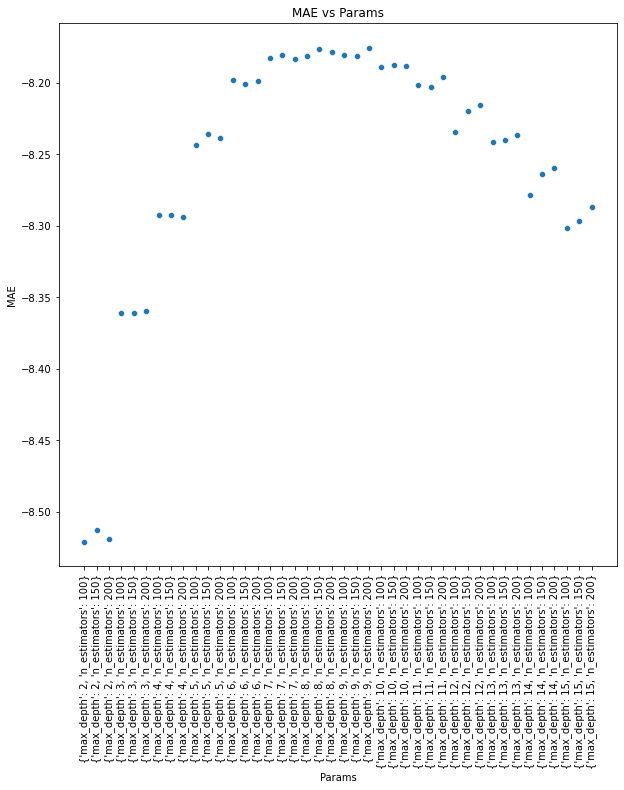

In [17]:
# Mostrar resultados
plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_rf.params.astype('string'), y=resultados_rf.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
0.02, 11.27


<Figure size 720x720 with 0 Axes>

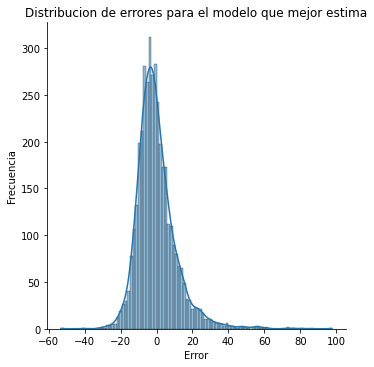

In [18]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 2) Decision Tree Regressor

In [19]:
# import the Model
# Done at the start


# Instantiate the empty model
model = DecisionTreeRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'criterion' : ['mae'],
            'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            'max_features' : ["auto"]
            }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_dt, MAE_dt, RMSE_dt = tune(grid, X, y)


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV 1/3] END criterion=mae, max_depth=2, max_features=auto;, score=-8.378 total time=  33.8s
[CV 2/3] END criterion=mae, max_depth=2, max_features=auto;, score=-8.312 total time=  35.0s
[CV 3/3] END criterion=mae, max_depth=2, max_features=auto;, score=-8.554 total time=  34.9s
[CV 1/3] END criterion=mae, max_depth=3, max_features=auto;, score=-8.146 total time=  40.0s
[CV 2/3] END criterion=mae, max_depth=3, max_features=auto;, score=-8.117 total time=  43.9s
[CV 3/3] END criterion=mae, max_depth=3, max_features=auto;, score=-8.334 total time=  46.3s
[CV 1/3] END criterion=mae, max_depth=4, max_features=auto;, score=-8.070 total time=  45.3s
[CV 2/3] END criterion=mae, max_depth=4, max_features=auto;, score=-8.048 total time=  46.4s
[CV 3/3] END criterion=mae, max_depth=4, max_features=auto;, score=-8.253 total time=  46.4s
[CV 1/3] END criterion=mae, max_depth=5, max_features=auto;, score=-8.050 total time=  45.8s
[CV 2/3] 

In [51]:
resultados_dt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,34.667626,0.527021,0.007667,0.000468,mae,2,auto,"{'criterion': 'mae', 'max_depth': 2, 'max_feat...",-8.377929,-8.312379,-8.554046,-8.414785,0.102044,8
1,43.491550,2.584728,0.008340,0.000472,mae,3,auto,"{'criterion': 'mae', 'max_depth': 3, 'max_feat...",-8.145774,-8.117185,-8.333791,-8.198917,0.096082,5
2,46.126428,0.521379,0.014348,0.000939,mae,4,auto,"{'criterion': 'mae', 'max_depth': 4, 'max_feat...",-8.069974,-8.047901,-8.253115,-8.123663,0.091979,3
3,42.897487,2.144133,0.005338,0.003775,mae,5,auto,"{'criterion': 'mae', 'max_depth': 5, 'max_feat...",-8.050208,-8.033203,-8.205242,-8.096218,0.077404,1
4,41.922574,0.534414,0.008544,0.006463,mae,6,auto,"{'criterion': 'mae', 'max_depth': 6, 'max_feat...",-8.036479,-8.052884,-8.217969,-8.102444,0.081962,2
5,42.348278,0.430274,0.013421,0.003120,mae,7,auto,"{'criterion': 'mae', 'max_depth': 7, 'max_feat...",-8.066290,-8.104956,-8.256487,-8.142578,0.082078,4
6,42.641823,0.817031,0.000000,0.000000,mae,8,auto,"{'criterion': 'mae', 'max_depth': 8, 'max_feat...",-8.143193,-8.195917,-8.392304,-8.243805,0.107188,6
7,43.055342,0.413629,0.000000,0.000000,mae,9,auto,"{'criterion': 'mae', 'max_depth': 9, 'max_feat...",-8.262704,-8.270872,-8.489897,-8.341158,0.105228,7
8,43.332490,0.357512,0.010413,0.007363,mae,10,auto,"{'criterion': 'mae', 'max_depth': 10, 'max_fea...",-8.439398,-8.414430,-8.670198,-8.508009,0.115137,9
9,43.996597,0.847701,0.005203,0.007359,mae,11,auto,"{'criterion': 'mae', 'max_depth': 11, 'max_fea...",-8.641669,-8.633143,-8.885844,-8.720219,0.117167,10


In [78]:
resultados_dt.to_csv('resultados_dt.csv')

In [21]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mae', max_depth=5, max_features='auto')>

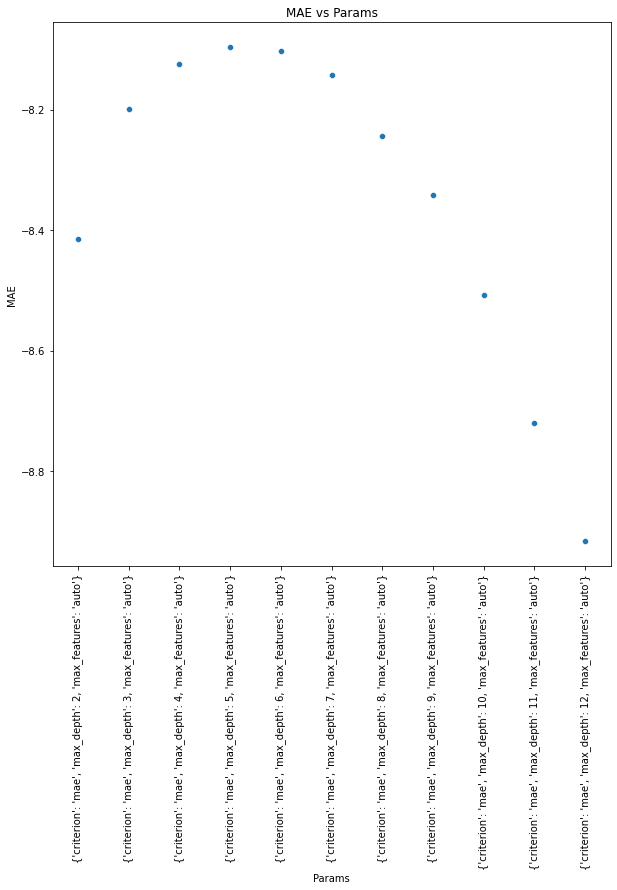

In [22]:
# Mostrar resultados
plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_dt.params.astype('string'), y=resultados_dt.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
2.29, 11.5


<Figure size 720x720 with 0 Axes>

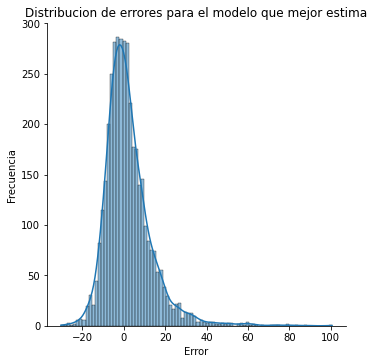

In [23]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 3) Ada Boost Tree

In [24]:
# import the Model
# Done at the start


# Instantiate the empty model
model = AdaBoostRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'n_estimators': [50,100],
            'learning_rate': [0.9, 0.95, 1.0, 1.05, 1.1],
            'loss' : ['linear'],
                }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_ab, MAE_ab, RMSE_ab = tune(grid, X, y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.9, loss=linear, n_estimators=50;, score=-12.096 total time=   1.2s
[CV 2/3] END learning_rate=0.9, loss=linear, n_estimators=50;, score=-11.622 total time=   1.0s
[CV 3/3] END learning_rate=0.9, loss=linear, n_estimators=50;, score=-12.569 total time=   1.3s
[CV 1/3] END learning_rate=0.9, loss=linear, n_estimators=100;, score=-11.188 total time=   1.2s
[CV 2/3] END learning_rate=0.9, loss=linear, n_estimators=100;, score=-12.470 total time=   1.0s
[CV 3/3] END learning_rate=0.9, loss=linear, n_estimators=100;, score=-14.480 total time=   1.7s
[CV 1/3] END learning_rate=0.95, loss=linear, n_estimators=50;, score=-12.739 total time=   1.3s
[CV 2/3] END learning_rate=0.95, loss=linear, n_estimators=50;, score=-14.089 total time=   1.3s
[CV 3/3] END learning_rate=0.95, loss=linear, n_estimators=50;, score=-19.643 total time=   2.9s
[CV 1/3] END learning_rate=0.95, loss=linear, n_estimators=100;, scor

In [52]:
resultados_ab

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.200851,0.116357,0.051154,0.014108,0.9,linear,50,"{'learning_rate': 0.9, 'loss': 'linear', 'n_es...",-12.096015,-11.621900,-12.569352,-12.095756,0.386795,1
1,1.352368,0.285204,0.057101,0.014463,0.9,linear,100,"{'learning_rate': 0.9, 'loss': 'linear', 'n_es...",-11.187774,-12.470179,-14.480254,-12.712736,1.355048,4
2,1.866626,0.710884,0.078132,0.033749,0.95,linear,50,"{'learning_rate': 0.95, 'loss': 'linear', 'n_e...",-12.738540,-14.088737,-19.642683,-15.489987,2.987688,10
3,1.255398,0.236089,0.052082,0.007365,0.95,linear,100,"{'learning_rate': 0.95, 'loss': 'linear', 'n_e...",-11.600356,-12.926570,-13.522856,-12.683260,0.803493,3
4,1.197950,0.261862,0.046875,0.012761,1.0,linear,50,"{'learning_rate': 1.0, 'loss': 'linear', 'n_es...",-12.531676,-12.402045,-15.058924,-13.330882,1.223056,7
5,1.257881,0.445387,0.052077,0.019491,1.0,linear,100,"{'learning_rate': 1.0, 'loss': 'linear', 'n_es...",-10.813976,-12.254965,-15.539215,-12.869385,1.977390,6
6,0.902368,0.219174,0.036518,0.007459,1.05,linear,50,"{'learning_rate': 1.05, 'loss': 'linear', 'n_e...",-11.379803,-10.570495,-15.273129,-12.407809,2.052850,2
7,1.342845,0.421895,0.046880,0.012766,1.05,linear,100,"{'learning_rate': 1.05, 'loss': 'linear', 'n_e...",-13.217410,-11.589602,-16.226676,-13.677896,1.920876,9
8,1.074483,0.250596,0.041666,0.007365,1.1,linear,50,"{'learning_rate': 1.1, 'loss': 'linear', 'n_es...",-11.499504,-11.495804,-15.611423,-12.868910,1.939250,5
9,1.145159,0.279012,0.047572,0.013618,1.1,linear,100,"{'learning_rate': 1.1, 'loss': 'linear', 'n_es...",-12.283798,-13.068039,-15.378428,-13.576755,1.313590,8


In [79]:
resultados_ab.to_csv('resultados_ab.csv')

In [26]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of AdaBoostRegressor(learning_rate=0.9)>

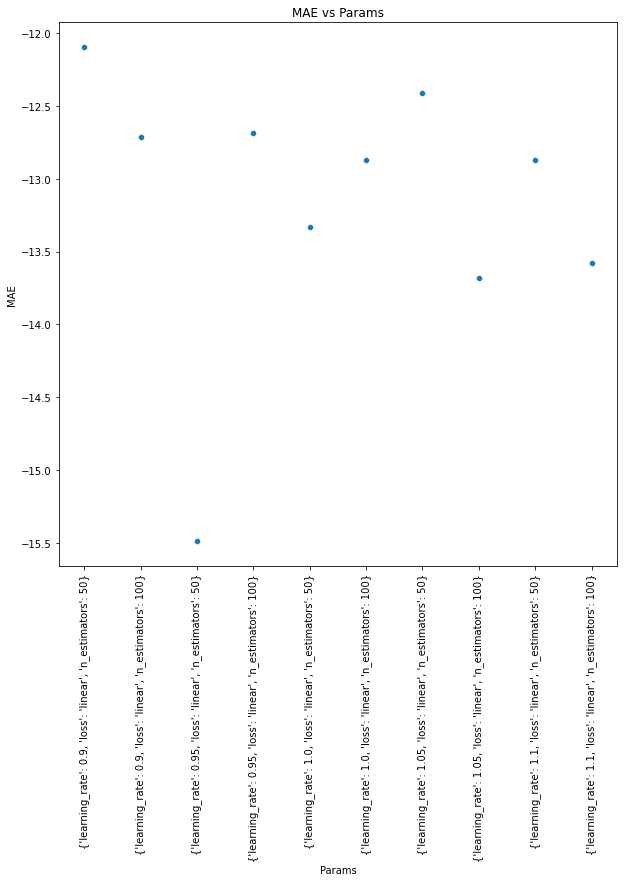

In [27]:
# Mostrar resultados
plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_ab.params.astype('string'), y=resultados_ab.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
-5.92, 11.97


<Figure size 720x720 with 0 Axes>

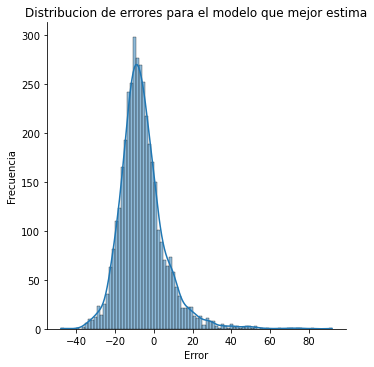

In [28]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 4) Gradient Boost Regressor

In [56]:
# import the Model
# Done at the start


# Instantiate the empty model
model = GradientBoostingRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'max_depth':[3,4,5,6,7],
            'learning_rate': [0.08, 0.085, 0.09, 0.095, 0.10, 0.105],
            'loss' : ['ls', 'huber'],
            'n_estimators': [100]
}

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_gb, MAE_gb, RMSE_gb = tune(grid, X, y)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END learning_rate=0.08, loss=ls, max_depth=3, n_estimators=100;, score=-8.119 total time=   5.6s
[CV 2/3] END learning_rate=0.08, loss=ls, max_depth=3, n_estimators=100;, score=-8.078 total time=   5.2s
[CV 3/3] END learning_rate=0.08, loss=ls, max_depth=3, n_estimators=100;, score=-8.154 total time=   5.2s
[CV 1/3] END learning_rate=0.08, loss=ls, max_depth=4, n_estimators=100;, score=-8.101 total time=   6.9s
[CV 2/3] END learning_rate=0.08, loss=ls, max_depth=4, n_estimators=100;, score=-8.069 total time=   6.9s
[CV 3/3] END learning_rate=0.08, loss=ls, max_depth=4, n_estimators=100;, score=-8.117 total time=   6.9s
[CV 1/3] END learning_rate=0.08, loss=ls, max_depth=5, n_estimators=100;, score=-8.101 total time=   8.6s
[CV 2/3] END learning_rate=0.08, loss=ls, max_depth=5, n_estimators=100;, score=-8.058 total time=   8.5s
[CV 3/3] END learning_rate=0.08, loss=ls, max_depth=5, n_estimators=100;, score=-8.119 tot

[CV 2/3] END learning_rate=0.09, loss=huber, max_depth=3, n_estimators=100;, score=-7.904 total time=   6.4s
[CV 3/3] END learning_rate=0.09, loss=huber, max_depth=3, n_estimators=100;, score=-8.062 total time=   6.4s
[CV 1/3] END learning_rate=0.09, loss=huber, max_depth=4, n_estimators=100;, score=-7.921 total time=   8.4s
[CV 2/3] END learning_rate=0.09, loss=huber, max_depth=4, n_estimators=100;, score=-7.888 total time=   8.5s
[CV 3/3] END learning_rate=0.09, loss=huber, max_depth=4, n_estimators=100;, score=-8.003 total time=   8.4s
[CV 1/3] END learning_rate=0.09, loss=huber, max_depth=5, n_estimators=100;, score=-7.919 total time=  10.7s
[CV 2/3] END learning_rate=0.09, loss=huber, max_depth=5, n_estimators=100;, score=-7.881 total time=  10.8s
[CV 3/3] END learning_rate=0.09, loss=huber, max_depth=5, n_estimators=100;, score=-7.981 total time=  10.7s
[CV 1/3] END learning_rate=0.09, loss=huber, max_depth=6, n_estimators=100;, score=-7.918 total time=  13.5s
[CV 2/3] END learni

[CV 1/3] END learning_rate=0.105, loss=ls, max_depth=4, n_estimators=100;, score=-8.088 total time=   6.8s
[CV 2/3] END learning_rate=0.105, loss=ls, max_depth=4, n_estimators=100;, score=-8.061 total time=   6.8s
[CV 3/3] END learning_rate=0.105, loss=ls, max_depth=4, n_estimators=100;, score=-8.122 total time=   6.8s
[CV 1/3] END learning_rate=0.105, loss=ls, max_depth=5, n_estimators=100;, score=-8.100 total time=   8.4s
[CV 2/3] END learning_rate=0.105, loss=ls, max_depth=5, n_estimators=100;, score=-8.056 total time=   8.5s
[CV 3/3] END learning_rate=0.105, loss=ls, max_depth=5, n_estimators=100;, score=-8.126 total time=   8.4s
[CV 1/3] END learning_rate=0.105, loss=ls, max_depth=6, n_estimators=100;, score=-8.123 total time=  10.2s
[CV 2/3] END learning_rate=0.105, loss=ls, max_depth=6, n_estimators=100;, score=-8.092 total time=  10.1s
[CV 3/3] END learning_rate=0.105, loss=ls, max_depth=6, n_estimators=100;, score=-8.153 total time=  10.1s
[CV 1/3] END learning_rate=0.105, los

In [57]:
resultados_gb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.377722,0.177101,0.035039,5.369118e-03,0.08,ls,3,100,"{'learning_rate': 0.08, 'loss': 'ls', 'max_dep...",-8.119415,-8.077717,-8.153971,-8.117034,0.031176,50
1,6.922308,0.009630,0.046875,8.920806e-07,0.08,ls,4,100,"{'learning_rate': 0.08, 'loss': 'ls', 'max_dep...",-8.100843,-8.069161,-8.117078,-8.095694,0.019898,36
2,8.597755,0.022662,0.067708,1.948767e-02,0.08,ls,5,100,"{'learning_rate': 0.08, 'loss': 'ls', 'max_dep...",-8.101140,-8.058315,-8.118646,-8.092700,0.025343,33
3,10.339410,0.084972,0.062680,2.443064e-04,0.08,ls,6,100,"{'learning_rate': 0.08, 'loss': 'ls', 'max_dep...",-8.110020,-8.079447,-8.137954,-8.109140,0.023894,46
4,11.994396,0.027202,0.083330,7.371712e-03,0.08,ls,7,100,"{'learning_rate': 0.08, 'loss': 'ls', 'max_dep...",-8.137480,-8.102009,-8.180388,-8.139959,0.032046,55
5,6.783127,0.151363,0.036463,7.361879e-03,0.08,huber,3,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-7.964195,-7.910944,-8.066551,-7.980563,0.064572,30
6,8.645978,0.034653,0.046903,3.123981e-05,0.08,huber,4,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-7.929174,-7.897859,-8.008661,-7.945232,0.046638,18
7,10.899559,0.044657,0.062500,6.836514e-07,0.08,huber,5,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-7.918204,-7.878388,-7.984543,-7.927045,0.043786,3
8,13.758341,0.078518,0.067708,7.365246e-03,0.08,huber,6,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-7.917241,-7.884492,-7.997223,-7.932985,0.047350,11
9,17.424549,0.116196,0.078125,6.743496e-07,0.08,huber,7,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-7.934507,-7.902408,-8.032907,-7.956608,0.055521,20


In [80]:
resultados_gb.to_csv('resultados_gb.csv')

In [58]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(loss='huber', max_depth=5)>

In [65]:
resultados_gb['loss'] = resultados_gb['params'].apply(lambda x: x.get('loss'))

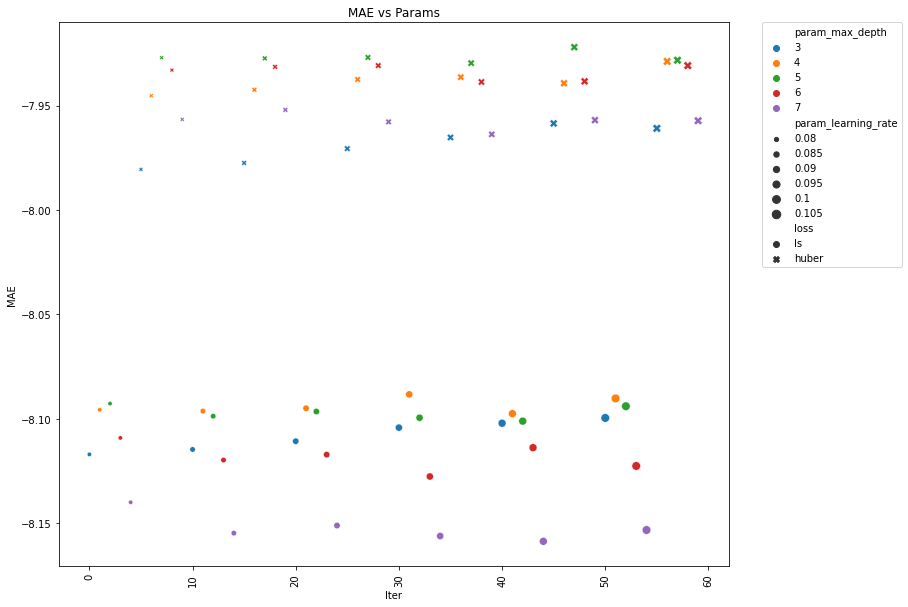

In [83]:
# Mostrar resultados
plt.figure(figsize=(12,10))
sns.scatterplot(x=resultados_gb.index, y=resultados_gb.mean_test_score, hue=resultados_gb.param_max_depth, size=resultados_gb.param_learning_rate, style=resultados_gb.loss, palette='tab10')
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Iter');
plt. xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

errors_mean, errors_std
1.13, 11.24


<Figure size 720x720 with 0 Axes>

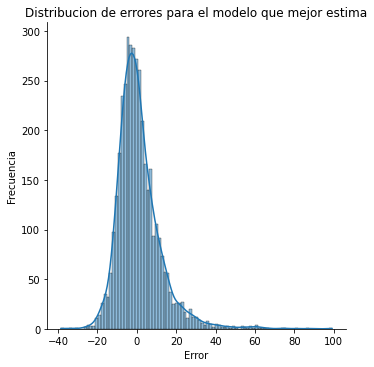

In [73]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 5) Support Vector Machine Regressor

In [34]:
# import the Model
# Done at the start


# Instantiate the empty model
model = SVR()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error


# Define params as dictionary

params = {
            'C': [ 0.1, 1, 10, 100],
            'epsilon': [0.001, 0.01, 0.1]
                }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...

# Scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc_holdout = scaler.transform(X_holdout)

# Compute and save
resultados_svr, MAE_svr, RMSE_svr = tune_sc(grid, X_sc, y)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .............C=0.1, epsilon=0.001;, score=-8.361 total time= 1.8min
[CV 2/3] END .............C=0.1, epsilon=0.001;, score=-8.273 total time= 1.8min
[CV 3/3] END .............C=0.1, epsilon=0.001;, score=-8.509 total time= 1.8min
[CV 1/3] END ..............C=0.1, epsilon=0.01;, score=-8.361 total time= 1.8min
[CV 2/3] END ..............C=0.1, epsilon=0.01;, score=-8.273 total time= 1.8min
[CV 3/3] END ..............C=0.1, epsilon=0.01;, score=-8.509 total time= 1.8min
[CV 1/3] END ...............C=0.1, epsilon=0.1;, score=-8.362 total time= 1.8min
[CV 2/3] END ...............C=0.1, epsilon=0.1;, score=-8.272 total time= 1.8min
[CV 3/3] END ...............C=0.1, epsilon=0.1;, score=-8.510 total time= 1.8min
[CV 1/3] END ...............C=1, epsilon=0.001;, score=-7.979 total time= 1.8min
[CV 2/3] END ...............C=1, epsilon=0.001;, score=-7.952 total time= 1.8min
[CV 3/3] END ...............C=1, epsilon=0.001;,

In [54]:
resultados_svr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,63.736349,0.160937,44.263075,0.061069,0.1,0.001,"{'C': 0.1, 'epsilon': 0.001}",-8.361357,-8.273300,-8.509309,-8.381322,0.097379,11
1,63.569376,0.105488,44.464441,0.088069,0.1,0.01,"{'C': 0.1, 'epsilon': 0.01}",-8.361330,-8.273174,-8.509486,-8.381330,0.097505,12
2,63.659238,0.491680,44.630683,0.272238,0.1,0.1,"{'C': 0.1, 'epsilon': 0.1}",-8.362132,-8.272262,-8.509557,-8.381317,0.097820,10
3,63.457950,0.252025,44.678730,0.285021,1,0.001,"{'C': 1, 'epsilon': 0.001}",-7.978596,-7.952078,-8.131914,-8.020863,0.079268,6
4,63.916079,0.421393,44.744523,0.329230,1,0.01,"{'C': 1, 'epsilon': 0.01}",-7.978425,-7.951776,-8.132039,-8.020747,0.079444,5
5,64.927733,0.288043,45.000916,0.366837,1,0.1,"{'C': 1, 'epsilon': 0.1}",-7.978017,-7.950444,-8.132687,-8.020383,0.080205,4
6,68.341065,1.084339,46.292239,1.321967,10,0.001,"{'C': 10, 'epsilon': 0.001}",-7.953709,-7.931753,-8.095611,-7.993691,0.072623,2
7,66.566818,0.666196,45.905679,1.303292,10,0.01,"{'C': 10, 'epsilon': 0.01}",-7.953745,-7.931770,-8.095612,-7.993709,0.072613,3
8,66.626638,0.303531,44.413622,0.599904,10,0.1,"{'C': 10, 'epsilon': 0.1}",-7.953251,-7.932711,-8.093251,-7.993071,0.071333,1
9,107.077023,5.332685,44.744667,0.185351,100,0.001,"{'C': 100, 'epsilon': 0.001}",-8.073544,-8.035096,-8.171137,-8.093259,0.057261,9


In [81]:
resultados_svr.to_csv('resultados_svr.csv')

In [36]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of SVR(C=10)>

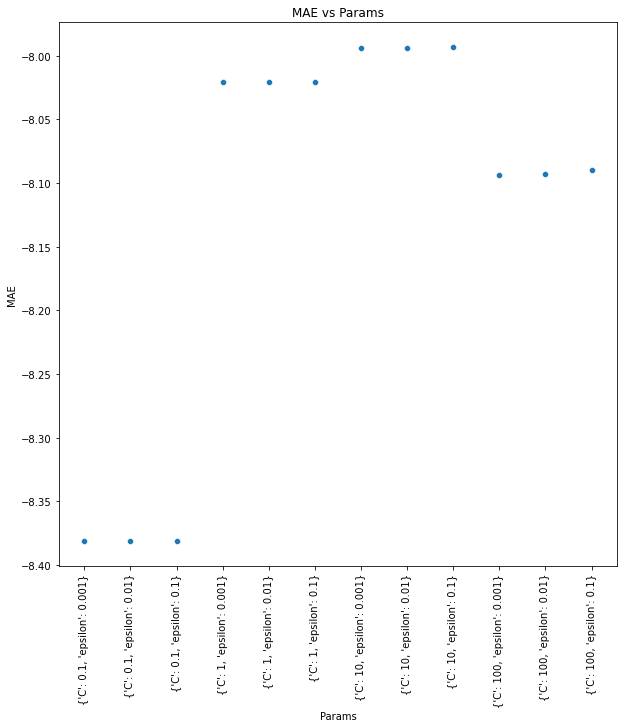

In [37]:
# Mostrar resultados

plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_svr.params.astype('string'), y=resultados_svr.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
-5.09, 14.3


<Figure size 720x720 with 0 Axes>

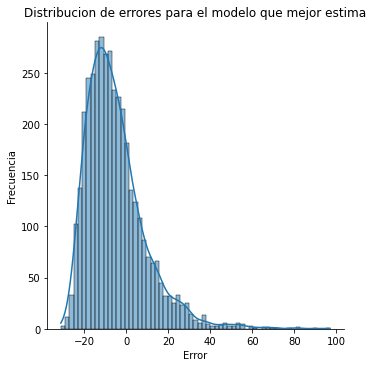

In [38]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_sc_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 6) Results

In [74]:
df = pd.DataFrame({
    "Algoritmo": ['Modelo actual','Decision Tree','Random Forest','Ada Boost','Gradient Boost','SVM','ANN'],
    "MAE": [MAE_py, MAE_dt, MAE_rf, MAE_ab, MAE_gb, MAE_svr, 7.94],
    "RMSE": [RMSE_py, RMSE_dt, RMSE_rf, RMSE_ab, RMSE_gb, RMSE_svr, 11.54]
})

In [75]:
df.sort_values(by=['MAE','RMSE'], inplace=True)

In [82]:
df.to_csv('resultados.csv')

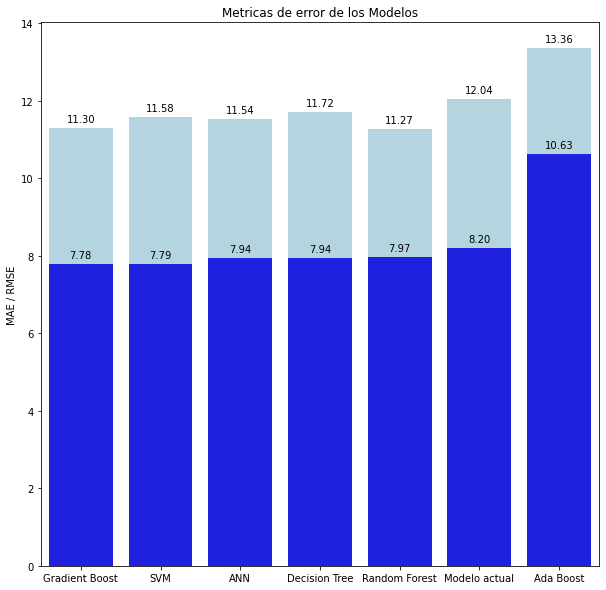

In [76]:
plt.figure(figsize=(10,10))

s1 = sns.barplot(x = 'Algoritmo', y = 'RMSE', data = df, color = 'lightblue')

s2 = sns.barplot(x = 'Algoritmo', y = 'MAE', data = df, color = 'blue')

for p in s1.patches:
    s1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.title('Metricas de error de los Modelos')
plt.ylabel('MAE / RMSE')
plt.xlabel('');